In [33]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(0)

class PINN(nn.Module):
    def __init__(self,data, layers, act=nn.Tanh()):
        super().__init__()
        self.data = {k: v.to(device) for k, v in data.items()}
        self.layers = layers
        self.act = act
        
        modules = []
        for i in range(len(layers) - 2):
            modules.append(nn.Linear(layers[i], layers[i + 1]))
            nn.init.xavier_normal_(modules[-1].weight)
            modules.append(self.act)
        
        modules.append(nn.Linear(layers[-2], layers[-1]))
        nn.init.xavier_normal_(modules[-1].weight)
        self.net = nn.Sequential(*modules)


    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

    def compute_PDE_loss(self,c=1):
        x_f = self.prep_tensor(self.data["x_f"], requires_grad=True)
        t_f = self.prep_tensor(self.data["t_f"], requires_grad=True)

        u_f = self(x_f,t_f)

        u_dx, u_dt = grad(u_f, (x_f, t_f), torch.ones_like(u_f),retain_graph=True, create_graph=True)
        u_ddx = grad(u_dx, x_f, torch.ones_like(u_f),create_graph=True)[0]
        u_ddt = grad(u_dt, t_f, torch.ones_like(u_f),create_graph=True)[0]

        residual = u_ddt - u_ddx*c**2
        residual = torch.mean(residual**2)
    
        return residual

    def compute_boundary_loss(self):
        x_bc = self.prep_tensor(self.data["x_bc"])
        t_bc = self.prep_tensor(self.data["t_bc"])
        u_bc = self.prep_tensor(self.data["u_bc"])

        u_bc_pred = self(x_bc,t_bc)
        bc_loss = torch.mean((u_bc_pred - u_bc)**2)
        return bc_loss
    
    def compute_initial_condition_loss(self):
        x_ic = self.prep_tensor(self.data["x_ic"], requires_grad=True)
        t_ic = self.prep_tensor(self.data["t_ic"], requires_grad=True)
        u_ic = self.prep_tensor(self.data["u_ic"], requires_grad=True)
        u_t_ic = self.prep_tensor(self.data["u_t_ic"])

        u_ic_pred = self(x_ic,t_ic)
        u_t = grad(u_ic_pred, t_ic, torch.ones_like(u_ic_pred), create_graph=True)[0]
        ic_loss = torch.mean((u_ic_pred - u_ic)**2) + torch.mean((u_t - u_t_ic)**2)
        return ic_loss

    def compute_data_loss(self):
        x_data = self.prep_tensor(self.data["x_data"], requires_grad=True)
        t_data = self.prep_tensor(self.data["t_data"], requires_grad=True)
        u_data = self.prep_tensor(self.data["u_data"])

        u_data_pred = self(x_data,t_data)
        data_loss = torch.mean((u_data_pred - u_data)**2)
        return data_loss

    def compute_total_loss(self, lambda_f=1.0, lambda_bc=1.0, lambda_ic=1.0, lambda_data=1.0):
        pde_loss = self.compute_PDE_loss()*lambda_f
        bc_loss = self.compute_boundary_loss()*lambda_bc
        ic_loss = self.compute_initial_condition_loss()*lambda_ic
        data_loss = self.compute_data_loss()*lambda_data
        
        total_loss = lambda_f*pde_loss + lambda_bc*bc_loss + lambda_ic*ic_loss + lambda_data*data_loss
        
        loss_for_display = {
            "total_loss": total_loss.item(),
            "pde_loss": lambda_f*pde_loss.item(),
            "bc_loss": lambda_bc*bc_loss.item(),
            "ic_loss": lambda_ic*ic_loss.item(),
            "data_loss": lambda_data*data_loss.item()}
        
        return total_loss, loss_for_display

    def prep_tensor(self, x, requires_grad=False):
        return x.clone().detach().to(device).requires_grad_(requires_grad)

    def train_model(self, niter):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        for it in range(niter):
            optimizer.zero_grad()
            loss, loss_for_display = self.compute_total_loss()
            loss.backward()
            optimizer.step()
            # break
            if it % 200 == 0:
                print(f"Iter: {it}, Loss: {loss.item():.4e}, PDE Loss: {loss_for_display['pde_loss']:.4e}, BC Loss: {loss_for_display['bc_loss']:.4e}, IC Loss: {loss_for_display['ic_loss']:.4e}, Data Loss: {loss_for_display['data_loss']:.4e}")
    
    def predict(self, x, t):
        x = x.clone().detach().to(device)
        t = t.clone().detach().to(device)
        u = self(x,t)
        return u.detach().cpu().numpy()

N_bc = 100
N_ic = 100
N_f = 20000
t_end = 12*np.pi
# Define boundary conditions
x_bc = torch.cat([torch.zeros(N_bc, 1), torch.ones(N_bc, 1)])*np.pi
t_bc = torch.rand(2*N_bc, 1, requires_grad=True)*t_end
u_bc = torch.ones((2*N_bc, 1))*0.0

# Define initial conditions
x_ic = torch.rand(N_ic, 1)*np.pi
t_ic = torch.zeros(N_ic, 1)
u_ic = torch.zeros(N_ic, 1)
u_t_ic = torch.sin(x_ic)

#Define PDE collocation points
def u_sol(t,x,n,Kn = 1,l = np.pi,c = 1):
        return Kn*np.sin(n*np.pi/l*(c*t))*np.sin(n*np.pi/l*x)

x_f = torch.rand(N_f, 1)*np.pi
t_f = torch.rand(N_f, 1)*t_end
# u_f = u_sol(t_f,x_f,n =1)

#Defining the data points
x_data = torch.tensor([[np.pi/2]])
t_data = torch.tensor([[0.0]])
u_data = torch.tensor([[0.0]])

data = {
    "x_bc": x_bc, "t_bc": t_bc, "u_bc": u_bc,
    "x_ic": x_ic, "t_ic": t_ic, "u_ic": u_ic, "u_t_ic": u_t_ic,
    "x_f": x_f, "t_f": t_f,
    "x_data": x_data, "t_data": t_data, "u_data": u_data
}

layers = [2,40,40,40,40,40,40,40,1]
model = PINN(data, layers).to(device)


x = torch.tensor([[np.pi/2]])
t = torch.tensor([[0.0]])
u_true = torch.tensor([[0.0]])


#Gathering everything needed for model setup in data



# model.compute_total_loss(x,t,torch.tensor([[0.0]],device=device))
# model.compute_boundary_loss()
model.train_model(60000)








Iter: 0, Loss: 8.0639e-01, PDE Loss: 1.7312e-04, BC Loss: 5.6298e-02, IC Loss: 6.1033e-01, Data Loss: 1.3959e-01
Iter: 200, Loss: 9.1623e-03, PDE Loss: 5.8478e-03, BC Loss: 1.2202e-03, IC Loss: 2.0941e-03, Data Loss: 2.2584e-07
Iter: 400, Loss: 4.9645e-03, PDE Loss: 3.8082e-03, BC Loss: 8.6252e-04, IC Loss: 2.9330e-04, Data Loss: 5.0530e-07
Iter: 600, Loss: 4.1456e-03, PDE Loss: 2.9885e-03, BC Loss: 1.0001e-03, IC Loss: 1.5690e-04, Data Loss: 9.8510e-08
Iter: 800, Loss: 3.6888e-03, PDE Loss: 2.4638e-03, BC Loss: 1.0829e-03, IC Loss: 1.4169e-04, Data Loss: 4.3185e-07
Iter: 1000, Loss: 3.3800e-03, PDE Loss: 2.1177e-03, BC Loss: 1.1223e-03, IC Loss: 1.3938e-04, Data Loss: 6.0124e-07
Iter: 1200, Loss: 5.0285e-03, PDE Loss: 1.7787e-03, BC Loss: 1.1584e-03, IC Loss: 9.9036e-04, Data Loss: 1.1011e-03
Iter: 1400, Loss: 2.9169e-03, PDE Loss: 1.6718e-03, BC Loss: 1.1329e-03, IC Loss: 1.1108e-04, Data Loss: 1.1542e-06
Iter: 1600, Loss: 3.5296e-03, PDE Loss: 1.5360e-03, BC Loss: 1.0980e-03, IC Los

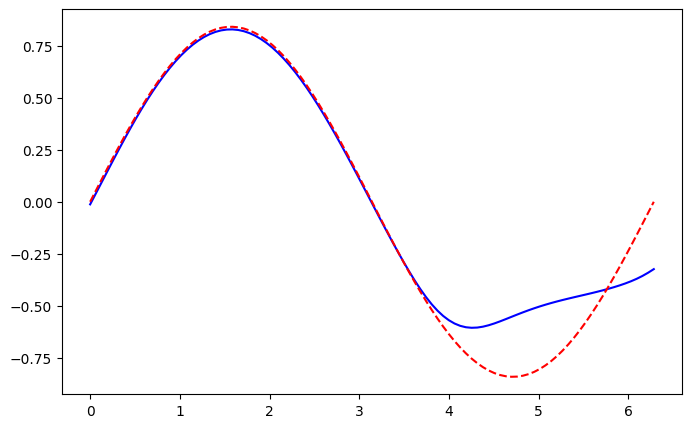

In [42]:
t_val = 1

X_test = torch.linspace(0, np.pi*2, 100).reshape(-1, 1)
T_test = torch.ones_like(X_test)*t_val

u_pred = model.predict(X_test, T_test)
u_true = u_sol(t_val, X_test.numpy(), n=1)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(X_test, u_pred, label='Predicted', color='blue')
ax.plot(X_test, u_true, label='Exact', color='red', linestyle='dashed')


In [149]:
data = {
    "x_bc": x_bc, "t_bc": t_bc, "u_bc": u_bc,
    "x_ic": x_ic, "t_ic": t_ic, "u_ic": u_ic, "u_t_ic": u_t_ic,
    "x_f": x_f, "t_f": t_f
}


x_bc torch.Size([600, 1])
t_bc torch.Size([600, 1])
u_bc torch.Size([600, 1])
x_ic torch.Size([300, 1])
t_ic torch.Size([300, 1])
u_ic torch.Size([300, 1])
u_t_ic torch.Size([300, 1])
x_f torch.Size([30000, 1])
t_f torch.Size([30000, 1])


In [25]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import time
from scipy.io import loadmat
from scipy.interpolate import griddata
from pyDOE import lhs

torch.manual_seed(1234)
np.random.seed(1234)


class PhysicsInformedNN(nn.Module):
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, device="cpu"):
        super(PhysicsInformedNN, self).__init__()

        self.lb = torch.tensor(lb, dtype=torch.float32, device=device)
        self.ub = torch.tensor(ub, dtype=torch.float32, device=device)
        self.device = device

        # Training data
        self.x0 = torch.tensor(x0, dtype=torch.float32, device=device)
        self.t0 = torch.tensor(np.zeros_like(x0), dtype=torch.float32, device=device)
        self.u0 = torch.tensor(u0, dtype=torch.float32, device=device)
        self.v0 = torch.tensor(v0, dtype=torch.float32, device=device)

        self.x_lb = torch.tensor(np.zeros_like(tb) + lb[0], dtype=torch.float32, device=device)
        self.t_lb = torch.tensor(tb, dtype=torch.float32, device=device)
        self.x_ub = torch.tensor(np.zeros_like(tb) + ub[0], dtype=torch.float32, device=device)
        self.t_ub = torch.tensor(tb, dtype=torch.float32, device=device)

        self.x_f = torch.tensor(X_f[:, 0:1], dtype=torch.float32, device=device)
        self.t_f = torch.tensor(X_f[:, 1:2], dtype=torch.float32, device=device)

        # Define neural network
        self.layers = layers
        self.net = self.build_network(layers).to(device)

    def build_network(self, layers):
        """Fully-connected MLP with tanh activations."""
        modules = []
        for i in range(len(layers) - 2):
            modules.append(nn.Linear(layers[i], layers[i + 1]))
            nn.init.xavier_normal_(modules[-1].weight)
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))
        nn.init.xavier_normal_(modules[-1].weight)
        return nn.Sequential(*modules)

    def forward(self, x, t):
        X = torch.cat([x, t], dim=1)
        # scale input to [-1, 1]
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        uv = self.net(H)
        u = uv[:, 0:1]
        v = uv[:, 1:2]
        return u, v

    def net_uv(self, x, t):
        """Compute u, v and their spatial derivatives."""
        x.requires_grad_(True)
        t.requires_grad_(True)
        u, v = self.forward(x, t)

        u_x = autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        v_x = autograd.grad(v, x, torch.ones_like(v), create_graph=True, retain_graph=True)[0]
        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        """Compute PDE residuals f_u and f_v."""
        u, v, u_x, v_x = self.net_uv(x, t)
        u_t = autograd.grad(u, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
        v_t = autograd.grad(v, t, torch.ones_like(v), create_graph=True, retain_graph=True)[0]
        u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
        v_xx = autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True, retain_graph=True)[0]

        f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
        f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
        return f_u, f_v

    def loss_fn(self):
        """Physics-informed loss combining data, boundary, and PDE terms."""
        # Initial condition
        u0_pred, v0_pred = self.forward(self.x0, self.t0)
        mse_u0 = torch.mean((self.u0 - u0_pred) ** 2)
        mse_v0 = torch.mean((self.v0 - v0_pred) ** 2)

        # Boundary condition
        u_lb, v_lb, u_x_lb, v_x_lb = self.net_uv(self.x_lb, self.t_lb)
        u_ub, v_ub, u_x_ub, v_x_ub = self.net_uv(self.x_ub, self.t_ub)
        mse_bc = torch.mean((u_lb - u_ub) ** 2) + torch.mean((v_lb - v_ub) ** 2)
        mse_bc += torch.mean((u_x_lb - u_x_ub) ** 2) + torch.mean((v_x_lb - v_x_ub) ** 2)

        # PDE residual
        f_u, f_v = self.net_f_uv(self.x_f, self.t_f)
        mse_f = torch.mean(f_u ** 2) + torch.mean(f_v ** 2)

        loss = mse_u0 + mse_v0 + mse_bc + mse_f
        return loss

    def train_model(self, nIter, lr=1e-3):
        """Train using Adam, then switch to L-BFGS."""
        optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

        start_time = time.time()
        for it in range(nIter):
            optimizer.zero_grad()
            loss = self.loss_fn()
            loss.backward()
            optimizer.step()

            if it % 10 == 0:
                elapsed = time.time() - start_time
                print(f"It {it}, Loss {loss.item():.3e}, Time {elapsed:.2f}")
                start_time = time.time()

        # Switch to L-BFGS
        def closure():
            optimizer_LBFGS.zero_grad()
            loss = self.loss_fn()
            loss.backward()
            return loss

        optimizer_LBFGS = torch.optim.LBFGS(
            self.net.parameters(),
            max_iter=50000,
            tolerance_grad=1e-12,
            tolerance_change=1e-12,
            history_size=50,
            line_search_fn="strong_wolfe"
        )

        print("Starting L-BFGS optimization...")
        optimizer_LBFGS.step(closure)

    def predict(self, X_star):
        x_star = torch.tensor(X_star[:, 0:1], dtype=torch.float32, device=self.device)
        t_star = torch.tensor(X_star[:, 1:2], dtype=torch.float32, device=self.device)
        u_star, v_star = self.forward(x_star, t_star)
        f_u, f_v = self.net_f_uv(x_star, t_star)
        return (
            u_star.detach().cpu().numpy(),
            v_star.detach().cpu().numpy(),
            f_u.detach().cpu().numpy(),
            f_v.detach().cpu().numpy(),
        )


# ================================
# Example usage (like original)
# ================================
if __name__ == "__main__":
    noise = 0.0
    lb = np.array([-5.0, 0.0])
    ub = np.array([5.0, np.pi / 2])
    N0, N_b, N_f = 50, 50, 20000
    layers = [2, 100, 100, 100, 100, 2]

    data = loadmat("C:\\Users\\jakob\\Desktop\\Master thesis\\Gihub Code\\Master\\Notebooks\\Data\\NLS.mat")
    t = data["tt"].flatten()[:, None]
    x = data["x"].flatten()[:, None]
    Exact = data["uu"]
    Exact_u = np.real(Exact)
    Exact_v = np.imag(Exact)

    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact_u.T.flatten()[:, None]
    v_star = Exact_v.T.flatten()[:, None]
    h_star = np.sqrt(u_star**2 + v_star**2)

    # Initial & boundary data
    idx_x = np.random.choice(x.shape[0], N0, replace=False)
    x0 = x[idx_x, :]
    u0 = Exact_u[idx_x, 0:1]
    v0 = Exact_v[idx_x, 0:1]

    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t, :]

    X_f = lb + (ub - lb) * lhs(2, N_f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, device)

    start_time = time.time()
    model.train_model(50000)
    print("Training time: %.4f" % (time.time() - start_time))

    u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
    h_pred = np.sqrt(u_pred ** 2 + v_pred ** 2)

    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
    error_h = np.linalg.norm(h_star - h_pred, 2) / np.linalg.norm(h_star, 2)
    print(f"Error u: {error_u:e}")
    print(f"Error v: {error_v:e}")
    print(f"Error h: {error_h:e}")


It 0, Loss 1.751e+00, Time 0.38
It 10, Loss 5.402e-01, Time 0.73
It 20, Loss 4.634e-01, Time 0.71
It 30, Loss 4.550e-01, Time 0.71
It 40, Loss 4.438e-01, Time 0.71
It 50, Loss 4.382e-01, Time 0.72
It 60, Loss 4.349e-01, Time 0.72
It 70, Loss 4.304e-01, Time 0.71
It 80, Loss 4.254e-01, Time 0.72
It 90, Loss 4.188e-01, Time 0.71
It 100, Loss 4.103e-01, Time 0.72
It 110, Loss 3.994e-01, Time 0.72
It 120, Loss 3.850e-01, Time 0.71
It 130, Loss 3.637e-01, Time 0.71
It 140, Loss 3.297e-01, Time 0.72
It 150, Loss 2.810e-01, Time 0.72
It 160, Loss 2.280e-01, Time 0.72
It 170, Loss 1.853e-01, Time 0.72
It 180, Loss 1.624e-01, Time 0.71
It 190, Loss 1.504e-01, Time 0.72
It 200, Loss 1.397e-01, Time 0.71
It 210, Loss 1.298e-01, Time 0.71
It 220, Loss 1.209e-01, Time 0.71
It 230, Loss 1.126e-01, Time 0.72
It 240, Loss 1.056e-01, Time 0.71
It 250, Loss 1.019e-01, Time 0.72
It 260, Loss 9.638e-02, Time 0.72
It 270, Loss 9.093e-02, Time 0.71
It 280, Loss 8.730e-02, Time 0.71
It 290, Loss 8.412e-02, T

KeyboardInterrupt: 

In [9]:
# wave_pinn_fixed.py
import torch
import torch.nn as nn
from torch.autograd import grad
import math

# ----- Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
torch.set_default_dtype(torch.float32)

# ----- Derivative helper
def d(outputs, inputs, create_graph=True):
    """First derivative: ∂outputs/∂inputs via vector–Jacobian product with ones."""
    return grad(outputs, inputs, torch.ones_like(outputs), create_graph=create_graph)[0]

# ----- Network
class PINN(nn.Module):
    def __init__(self, in_dim=2, width=128, depth=4, act=nn.Tanh()):
        super().__init__()
        layers = []
        for i in range(depth):
            layers += [nn.Linear(in_dim if i == 0 else width, width), act]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        z = torch.cat([x, t], dim=1)  # (N,2)
        return self.net(z)

# ----- Problem setup
c = 1.0
N_f = 10_000   # collocation points
N_b = 1_000    # boundary points
N_i = 1_000    # initial line points

rand = lambda n: torch.rand(n, 1, device=device)

# Interior points (we differentiate w.r.t. these each step)
x_f = rand(N_f)
t_f = rand(N_f)

# Boundary points (no derivatives needed)
t_b = rand(N_b)
x_b0 = torch.zeros_like(t_b, device=device)
x_b1 = torch.ones_like(t_b, device=device)

# Initial line t=0 (we differentiate wrt t here)
x_i = rand(N_i)
t_i0 = torch.zeros_like(x_i, device=device)

# Ground-truth functions (for IC & evaluation)
def u_true(x, t):
    return torch.sin(math.pi * x) * torch.cos(math.pi * t)

def ut_true(x, t):
    return -math.pi * torch.sin(math.pi * x) * torch.sin(math.pi * t)

# IC targets (detach to avoid any graph ties)
with torch.no_grad():
    u0 = u_true(x_i, torch.zeros_like(x_i))
    v0 = ut_true(x_i, torch.zeros_like(x_i))  # equals 0 for this choice

# ----- Model & optimizer
model = PINN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = lambda x: torch.mean(x**2)

# ----- PDE residual
def pde_residual(net, x, t):
    u    = net(x, t)       # (N,1)
    u_t  = d(u, t)         # ∂u/∂t
    u_tt = d(u_t, t)       # ∂²u/∂t²
    u_x  = d(u, x)         # ∂u/∂x
    u_xx = d(u_x, x)       # ∂²u/∂x²
    return u_tt - (c**2) * u_xx

# ----- Training
steps = 500
for step in range(1, steps + 1):
    # Fresh leaves for tensors we differentiate w.r.t. this step
    x_f = x_f.detach().requires_grad_(True)
    t_f = t_f.detach().requires_grad_(True)
    x_i = x_i.detach().requires_grad_(True)
    t_i0 = t_i0.detach().requires_grad_(True)

    # PDE loss
    r = pde_residual(model, x_f, t_f)
    L_pde = mse(r)

    # Boundary (Dirichlet u=0 at x=0 and x=1) — no grads w.r.t. coords needed
    u_b0 = model(x_b0, t_b)
    u_b1 = model(x_b1, t_b)
    L_bc = mse(u_b0) + mse(u_b1)

    # Initial conditions at t=0: u(x,0)=sin(pi x), u_t(x,0)=0
    u_i  = model(x_i, t_i0)
    u_ti = d(u_i, t_i0)  # ∂u/∂t at t=0
    # u0, v0 are constants (no grad)
    L_ic = mse(u_i - u0) + mse(u_ti - v0)

    loss = L_pde + L_bc + L_ic

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    if step % 10 == 0:
        print(f"step {step:5d} | L_pde {L_pde.item():.3e} | L_bc {L_bc.item():.3e} | L_ic {L_ic.item():.3e} | total {loss.item():.3e}")

# ----- Evaluation
with torch.no_grad():
    nx, nt = 200, 200
    xg = torch.linspace(0, 1, nx, device=device).view(-1, 1)
    tg = torch.linspace(0, 1, nt, device=device).view(-1, 1)
    # default indexing in torch.meshgrid is fine here
    Xg, Tg = torch.meshgrid(xg.squeeze(1), tg.squeeze(1))
    x_flat = Xg.reshape(-1, 1)
    t_flat = Tg.reshape(-1, 1)

    up = model(x_flat, t_flat).reshape(nx, nt)
    ut = u_true(Xg, Tg)

    num = torch.linalg.norm((up - ut).reshape(-1))
    den = torch.linalg.norm(ut.reshape(-1))
    rel_l2 = (num / den).item()
    print(f"\nRelative L2 error on grid: {rel_l2:.3e}")


step    10 | L_pde 4.376e-05 | L_bc 3.826e-02 | L_ic 3.067e-01 | total 3.450e-01
step    20 | L_pde 1.886e-04 | L_bc 8.827e-02 | L_ic 2.396e-01 | total 3.280e-01
step    30 | L_pde 1.880e-04 | L_bc 7.512e-02 | L_ic 2.492e-01 | total 3.245e-01
step    40 | L_pde 1.359e-03 | L_bc 6.622e-02 | L_ic 2.518e-01 | total 3.193e-01
step    50 | L_pde 5.356e-04 | L_bc 7.694e-02 | L_ic 2.282e-01 | total 3.057e-01
step    60 | L_pde 1.832e-03 | L_bc 7.356e-02 | L_ic 2.125e-01 | total 2.879e-01
step    70 | L_pde 1.186e-03 | L_bc 6.405e-02 | L_ic 2.155e-01 | total 2.807e-01
step    80 | L_pde 3.735e-03 | L_bc 6.722e-02 | L_ic 1.931e-01 | total 2.640e-01
step    90 | L_pde 2.314e-02 | L_bc 6.665e-02 | L_ic 1.504e-01 | total 2.401e-01
step   100 | L_pde 1.711e-02 | L_bc 5.059e-02 | L_ic 1.388e-01 | total 2.065e-01
step   110 | L_pde 1.275e-02 | L_bc 5.673e-02 | L_ic 8.721e-02 | total 1.567e-01
step   120 | L_pde 1.457e-02 | L_bc 4.695e-02 | L_ic 5.338e-02 | total 1.149e-01
step   130 | L_pde 1.409e-02

c:\Users\jakob\anaconda3\envs\thesis\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
